In [1]:
import pandas as pd
import sys
import glob
import numpy as np
import datetime

import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as PC

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

In [2]:
csv_filepath = "/pscratch/sd/o/ocankur/data/resource_usage_paper"

In [3]:
def get_duration(dataframe, seconds=10):
    # remove jobs that take less than 10 secs.
    dataframe["start_time"] = pd.to_datetime(dataframe["start"], unit='s', utc=True)
    dataframe["end_time"] = pd.to_datetime(dataframe["end"], unit='s', utc=True)
    dataframe["duration"] = dataframe["end_time"] - dataframe["start_time"]
    dataframe = dataframe[dataframe["duration"] > datetime.timedelta(0,seconds)]
    return dataframe

In [4]:
def preprocess_data(ldms_dataframe, sacct_dataframe, metric, percentage=True):
    """
    Remove jobs that take less than 10 seconds.
    Filter out completed jobs.
    Filter out 'nstaff' and 'nstaff_g'
    """
    
    print("Number of LDMS data points before preprocessing: ", len(ldms_dataframe.index))
    
    if percentage:
        if metric == "mem_copy_utilization" or metric == "gpu_utilization":
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 100]
        else:
            ldms_dataframe = ldms_dataframe[ldms_dataframe[metric] <= 1]
    
    sacct_dataframe = get_duration(sacct_dataframe, 10)
    
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff_g"]
    sacct_dataframe = sacct_dataframe[sacct_dataframe["Account"] != "nstaff"]
    
    # sacct_dataframe = sacct_dataframe[sacct_dataframe["state"] == "COMPLETED"]
    
    sacct_dataframe.rename(columns={'jobidraw': 'jobid'}, inplace=True)
    merged_ldms = ldms_dataframe.merge(sacct_dataframe, on=["ProducerName", "jobid", "step"])
    
    print("Number of LDMS data points after preprocessing: ", len(merged_ldms.index))
    
    return merged_ldms

In [5]:
df_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_ldms.pq")
df_sacct_gputil = pd.read_parquet(csv_filepath + "/" + "dcgm.gpu_utilization.1692169200.1692428399.8.16_saact.pq")
merged_ldms_gputil = preprocess_data(df_gputil, df_sacct_gputil, metric="gpu_utilization", percentage=True)

Number of LDMS data points before preprocessing:  116803958
Number of LDMS data points after preprocessing:  85987227


In [6]:
jobs_with_g = merged_ldms_gputil[merged_ldms_gputil["Account"].str.contains("_g")]

In [7]:
jobs_without_g = merged_ldms_gputil[~merged_ldms_gputil["Account"].str.contains("_g")]

### CDF and PDF

/tmp/ipykernel_534742/912761647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jobs_with_g['duration_hours'] = jobs_with_g['duration'].dt.total_seconds() / 3600


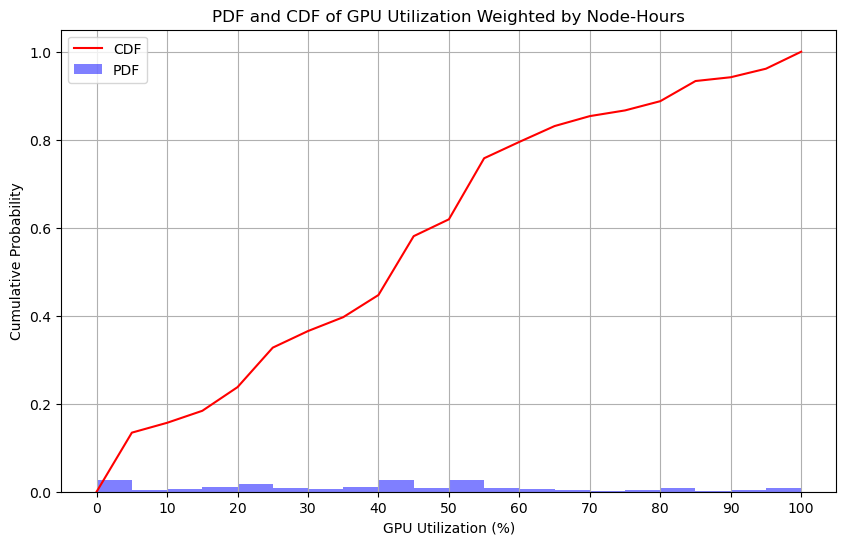

In [8]:
jobs_with_g['duration_hours'] = jobs_with_g['duration'].dt.total_seconds() / 3600

aggregated_data = jobs_with_g.groupby('jobid').agg({
    'nnodes': 'first',  
    'duration_hours': 'first',  
    'gpu_utilization': 'mean'  # Does that makes sense????
})

# Calculate node-hours by multiplying duration by nnodes
aggregated_data['node_hours'] = aggregated_data['duration_hours'] * aggregated_data['nnodes']

weighted_gpu_utilization = pd.DataFrame({
    'gpu_utilization': aggregated_data['gpu_utilization'],
    'weight': aggregated_data['node_hours']
})

bins = np.linspace(0, 100, 21) 

# Calculate histogram data for PDF
pdf_values, pdf_base = np.histogram(weighted_gpu_utilization['gpu_utilization'], bins=bins, weights=weighted_gpu_utilization['weight'], density=True)
pdf_widths = np.diff(pdf_base)
pdf_centers = pdf_base[:-1] + pdf_widths / 2

cdf_values, _ = np.histogram(weighted_gpu_utilization['gpu_utilization'], bins=bins, weights=weighted_gpu_utilization['weight'])
cdf_values = np.cumsum(cdf_values)  
cdf_values = np.insert(cdf_values, 0, 0)  
cdf_values = cdf_values / cdf_values[-1]

plt.figure(figsize=(10, 6))
plt.bar(pdf_centers, pdf_values, width=pdf_widths, color='blue', alpha=0.5, label='PDF')
plt.plot(pdf_base, cdf_values, color='red', label='CDF') 
plt.xlabel('GPU Utilization (%)')
plt.ylabel('Cumulative Probability')
plt.title('PDF and CDF of GPU Utilization Weighted by Node-Hours')
plt.xticks(np.arange(0, 101, 10))
plt.grid(True)
plt.legend()

plt.show()

### Summary of statistics. WIP: How to visualize without doing minimal aggregation?

In [7]:
# Group by 'jobid' and calculate summary statistics
summary_stats = jobs_with_g.groupby('jobid')['gpu_utilization'].describe(percentiles=[.25, .5, .75]).reset_index()

summary_stats

,jobid,count,mean,std,min,25%,50%,75%,max
0,13637517,1706.0,29.318288,44.826405,0.0,0.0,0.0,94.0,100.0
1,13637520,1670.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,13829694,184609.0,33.010157,44.071008,0.0,0.0,0.0,93.0,100.0
3,13889527,243997.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,13889532,254804.0,19.962830,1.296454,0.0,19.0,20.0,21.0,23.0
...,...,...,...,...,...,...,...,...,...
16139,14068349,115.0,47.347826,29.459173,0.0,0.0,61.0,61.0,83.0
16140,14068350,26125.0,0.127426,2.048007,0.0,0.0,0.0,0.0,82.0
16141,14068352,112.0,35.794643,31.919419,0.0,0.0,60.0,61.0,83.0
16142,14068358,108.0,41.990741,30.294657,0.0,0.0,59.0,60.0,84.0


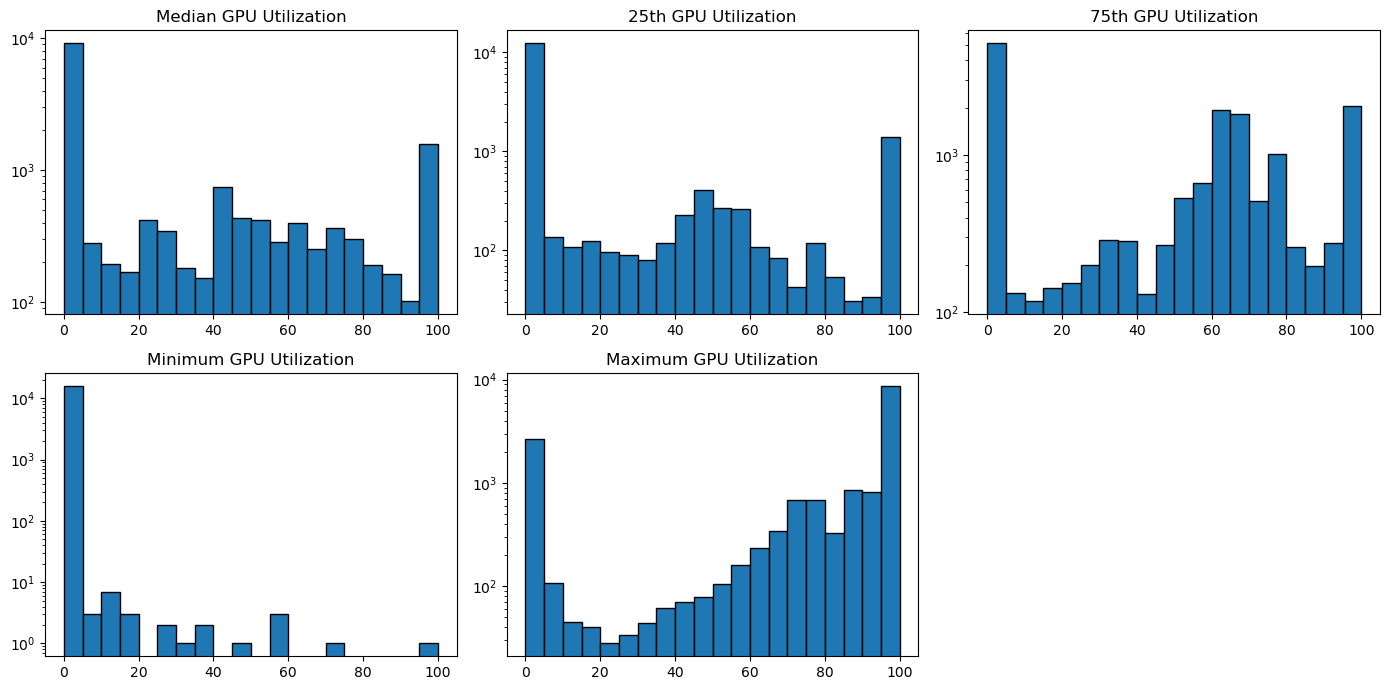

In [8]:
bins = range(0, 101, 5)  # 0-5, 5-10, ..., 95-100

plt.figure(figsize=(14, 7))

plt.subplot(2, 3, 1)
plt.hist(summary_stats['50%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Median GPU Utilization')

plt.subplot(2, 3, 2)
plt.hist(summary_stats['25%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('25th GPU Utilization')

plt.subplot(2, 3, 3)
plt.hist(summary_stats['75%'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('75th GPU Utilization')

plt.subplot(2, 3, 4)
plt.hist(summary_stats['min'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Minimum GPU Utilization')

plt.subplot(2, 3, 5)
plt.hist(summary_stats['max'], bins=bins, edgecolor='black')
plt.yscale('log') 
plt.title('Maximum GPU Utilization')

plt.tight_layout()
plt.show()

### Is a small fraction of users responsible for the majority of GPU usage?

In [11]:
mean_gpu_per_user = jobs_with_g.groupby('Account')['gpu_utilization'].mean().reset_index()
mean_gpu_per_user

,Account,gpu_utilization
0,als_g,23.083627
1,atlas_g,6.075435
2,dasrepo_g,77.155643
3,deepsrch_g,0.000000
4,des_g,37.201683
...,...,...
215,mpcray_g,0.000000
216,nintern_g,0.000000
217,ntrain1_g,7.634640
218,ntrain_g,5.193482


In [12]:
mean_gpu_per_user = mean_gpu_per_user.sort_values(by='gpu_utilization', ascending=False).reset_index(drop=True)
mean_gpu_per_user

,Account,gpu_utilization
0,m3980_g,96.082049
1,mp217_g,94.346321
2,m4351_g,93.961165
3,m2571_g,92.912792
4,m4129_g,92.822425
...,...,...
215,m4086_g,0.000000
216,m3210_g,0.000000
217,m4271_g,0.000000
218,m4078_g,0.000000


In [13]:
mean_gpu_per_user['cumulative_gpu'] = mean_gpu_per_user['gpu_utilization'].cumsum()
total_mean_gpu = mean_gpu_per_user['gpu_utilization'].sum()
mean_gpu_per_user['cumulative_percentage'] = mean_gpu_per_user['cumulative_gpu'] / total_mean_gpu
mean_gpu_per_user

,Account,gpu_utilization,cumulative_gpu,cumulative_percentage
0,m3980_g,96.082049,96.082049,0.015836
1,mp217_g,94.346321,190.428369,0.031386
2,m4351_g,93.961165,284.389535,0.046872
3,m2571_g,92.912792,377.302327,0.062186
4,m4129_g,92.822425,470.124752,0.077485
...,...,...,...,...
215,m4086_g,0.000000,6067.326977,1.000000
216,m3210_g,0.000000,6067.326977,1.000000
217,m4271_g,0.000000,6067.326977,1.000000
218,m4078_g,0.000000,6067.326977,1.000000


In [14]:
threshold = 0.80
fraction_of_users = (mean_gpu_per_user['cumulative_percentage'] <= threshold).sum() / len(mean_gpu_per_user)

print(f"Fraction of users responsible for {threshold*100}% of GPU usage: {fraction_of_users:.2%}")

Fraction of users responsible for 80.0% of GPU usage: 40.00%


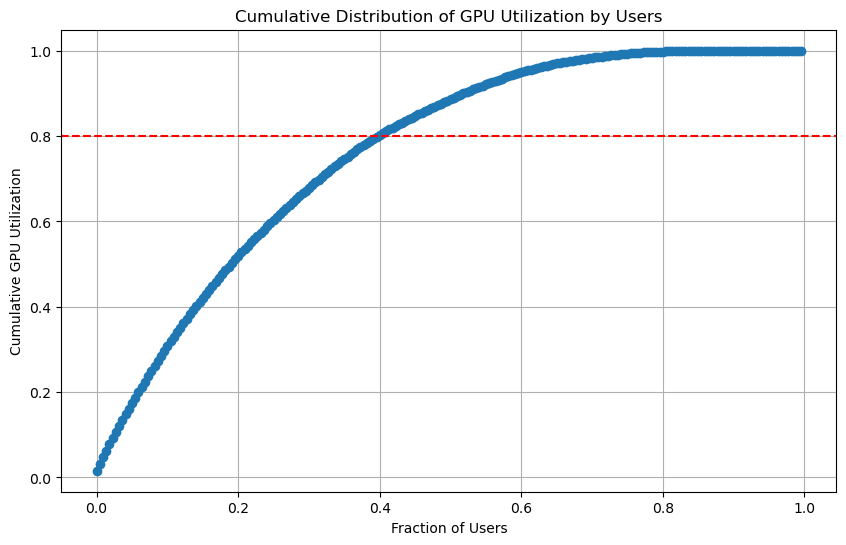

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(mean_gpu_per_user.index / len(mean_gpu_per_user), mean_gpu_per_user['cumulative_percentage'], marker='o')
plt.axhline(y=threshold, color='r', linestyle='--')
plt.xlabel('Fraction of Users')
plt.ylabel('Cumulative GPU Utilization')
plt.title('Cumulative Distribution of GPU Utilization by Users')
plt.grid(True)
plt.show()

### How many jobs are running on the GPU partition but have a GPU utilization value of 0 during the entire runtime of the application?
- 15.4% of jobs
- 4.47% of node hours

In [16]:
jobs_with_zero_gpu = jobs_with_g.groupby('jobid').filter(lambda x: x['gpu_utilization'].sum() == 0)

In [17]:
num_zero_gpu_jobs = jobs_with_zero_gpu['jobid'].nunique()
print(f"Number of jobs with 0 GPU utilization: {num_zero_gpu_jobs}")
print("Total number of jobs: ", jobs_with_g[["jobid"]].nunique())

Number of jobs with 0 GPU utilization: 2486
Total number of jobs:  jobid    16144
dtype: int64


In [18]:
unique_jobs_with_zero_gpu = jobs_with_zero_gpu.drop_duplicates(subset='jobid').copy()
unique_jobs_with_zero_gpu['duration_hours'] = unique_jobs_with_zero_gpu['duration'].dt.total_seconds() / 3600.0
unique_jobs_with_zero_gpu['node_hours'] = unique_jobs_with_zero_gpu['nnodes'] * unique_jobs_with_zero_gpu['duration_hours']

total_node_hours_with_zero_gpu = unique_jobs_with_zero_gpu['node_hours'].sum()
print(f"Total node hours for jobs with 0 GPU utilization: {total_node_hours_with_zero_gpu}")

Total node hours for jobs with 0 GPU utilization: 2709.755277777778


In [19]:
jobs_without_zero_gpu = jobs_with_g.groupby('jobid').filter(lambda x: x['gpu_utilization'].sum() != 0)
unique_jobs_without_zero_gpu = jobs_without_zero_gpu.drop_duplicates(subset='jobid').copy()
unique_jobs_without_zero_gpu['duration_hours'] = unique_jobs_without_zero_gpu['duration'].dt.total_seconds() / 3600.0
unique_jobs_without_zero_gpu['node_hours'] = unique_jobs_without_zero_gpu['nnodes'] * unique_jobs_without_zero_gpu['duration_hours']

total_node_hours = unique_jobs_without_zero_gpu['node_hours'].sum()
print(f"Total node hours for jobs with 0 GPU utilization: {total_node_hours}")

Total node hours for jobs with 0 GPU utilization: 57885.92138888889


### d